## Bayesian analysis of the positions taken by F1 drivers in each race of the 2022-2024 hybrid era.
### Andrzej Janik, Łukasz Gakan
### Data Analytics 2024
### Automatic Control and Robotics - Computer Science in Control and Management

### 1. Project formulation
The goal of the project is to conduct a Bayesian analysis of the places held by Formula One drivers in individual races in the hybrid era, spanning 2022-2024. The hybrid era, characterized by advanced hybrid powertrain technologies, has introduced new challenges and opportunities that significantly affect race results and team strategies. The analysis aims to identify patterns and factors affecting driver performance in this modern era, using Bayesian analysis tools. The project will collect and analyze data on the results of F1 races from 2022-2024, including drivers' starting and finishing positions, weather conditions, times and finishing positions from other sessions i.e qualifications, sprint qualifications, free practices. 

##### Point of creating model and potential use cases
Bayesian analysis will make it possible to model the relationship between these variables, identifying the key factors affecting drivers' final positions and to predict future results based on current data. This will enable better preparation of teams for future races, as well as a better understanding of the dynamics of competition in the hybrid era of Formula One. The analysis results can be utilized for educating new team members and drivers, helping them better understand the factors affecting their performance and to develop more effective strategies for upcoming races. Outcome can be highly useful for people involved in betting, as it can predict the positions of drivers with greater accuracy, thereby increasing the chances of winning bets. The last use case is that FIA (The Fédération Internationale de l'Automobile) can leverage the model to evaluate the impact of new technical regulations. This can help enhance the overall spectacle for fans by ensuring closer and more exciting races.

##### Description of data
The data for all sessions from the hybrid era (seasons 2022, 2023, 2024) were scraped from the official Formula 1 website (https://www.formula1.com), and the weather data were obtained using the FastF1 API. After that, the data from each race weekend were appropriately merged and sorted.
Below is the representation of all columns in the prepared dataset:

1. **Year**: The year in which the race took place.
2. **Race**: The name or location of the race.
3. **No**: The car number of the driver.
4. **Driver**: The name of the driver.
5. **Car**: The team or manufacturer of the car.
6. **Pos (race)**: The final position of the driver in the race.
7. **Laps (race)**: The number of laps completed by the driver in the race.
8. **Time/Retired**: The race completion time of the driver or the reason for retirement if the driver did not finish the race.
9. **Points**: The points awarded to the driver for the race.
10. **Pos (qualifying)**: The position of the driver in the qualifying session.
11. **Q1**: The time of the driver in the first qualifying session.
12. **Q2**: The time of the driver in the second qualifying session.
13. **Q3**: The time of the driver in the third qualifying session.
14. **Pos (FP1)**: The position of the driver in the first free practice session.
15. **Time (FP1)**: The time of the driver in the first free practice session.
16. **Gap (FP1)**: The time gap between the driver and the fastest driver in the first free practice session.
17. **Laps (FP1)**: The number of laps completed by the driver in the first free practice session.
18. **Pos (FP2)**: The position of the driver in the second free practice session.
19. **Time (FP2)**: The time of the driver in the second free practice session.
20. **Gap (FP2)**: The time gap between the driver and the fastest driver in the second free practice session.
21. **Laps (FP2)**: The number of laps completed by the driver in the second free practice session.
22. **Pos (FP3)**: The position of the driver in the third free practice session.
23. **Time (FP3)**: The time of the driver in the third free practice session.
24. **Gap (FP3)**: The time gap between the driver and the fastest driver in the third free practice session.
25. **Laps (FP3)**: The number of laps completed by the driver in the third free practice session.
26. **Pos (Sprint)**: The position of the driver in the sprint race (if sprint weekend).
27. **Laps (Sprint)**: The number of laps completed by the driver in the sprint race (if sprint weekend).
28. **Time/Retired (Sprint)**: The sprint race completion time of the driver or the reason for retirement if the driver did not finish the sprint race (if sprint weekend).
29. **Points (Sprint)**: The points awarded to the driver for the sprint race (if sprint weekend).
30. **Pos (Sprint Quali)**: The position of the driver in the sprint qualifying session (if sprint weekend).
31. **SQ1**: The time of the driver in the first sprint qualifying session (if sprint weekend).
32. **SQ2**: The time of the driver in the second sprint qualifying session (if sprint weekend).
33. **SQ3**: The time of the driver in the third sprint qualifying session (if asprint weekend).
34. **Laps (Sprint Quali)**: The number of laps completed by the driver in the sprint qualifying session (if sprint weekend).
35. **AvgAirTemp**: The average air temperature during the race.
36. **AvgHumidity**: The average humidity during the race.
37. **AvgPressure**: The average atmospheric pressure during the race.
38. **TotalRainfall**: The total rainfall during the race.
39. **AvgTrackTemp**: The average track temperature during the race.
40. **AvgWindDirection**: The average wind direction during the race.
41. **AvgWindSpeed**: The average wind speed during the race.

##### DAG
To visualize the relationships between the variables, we use a Directed Acyclic Graph (DAG):

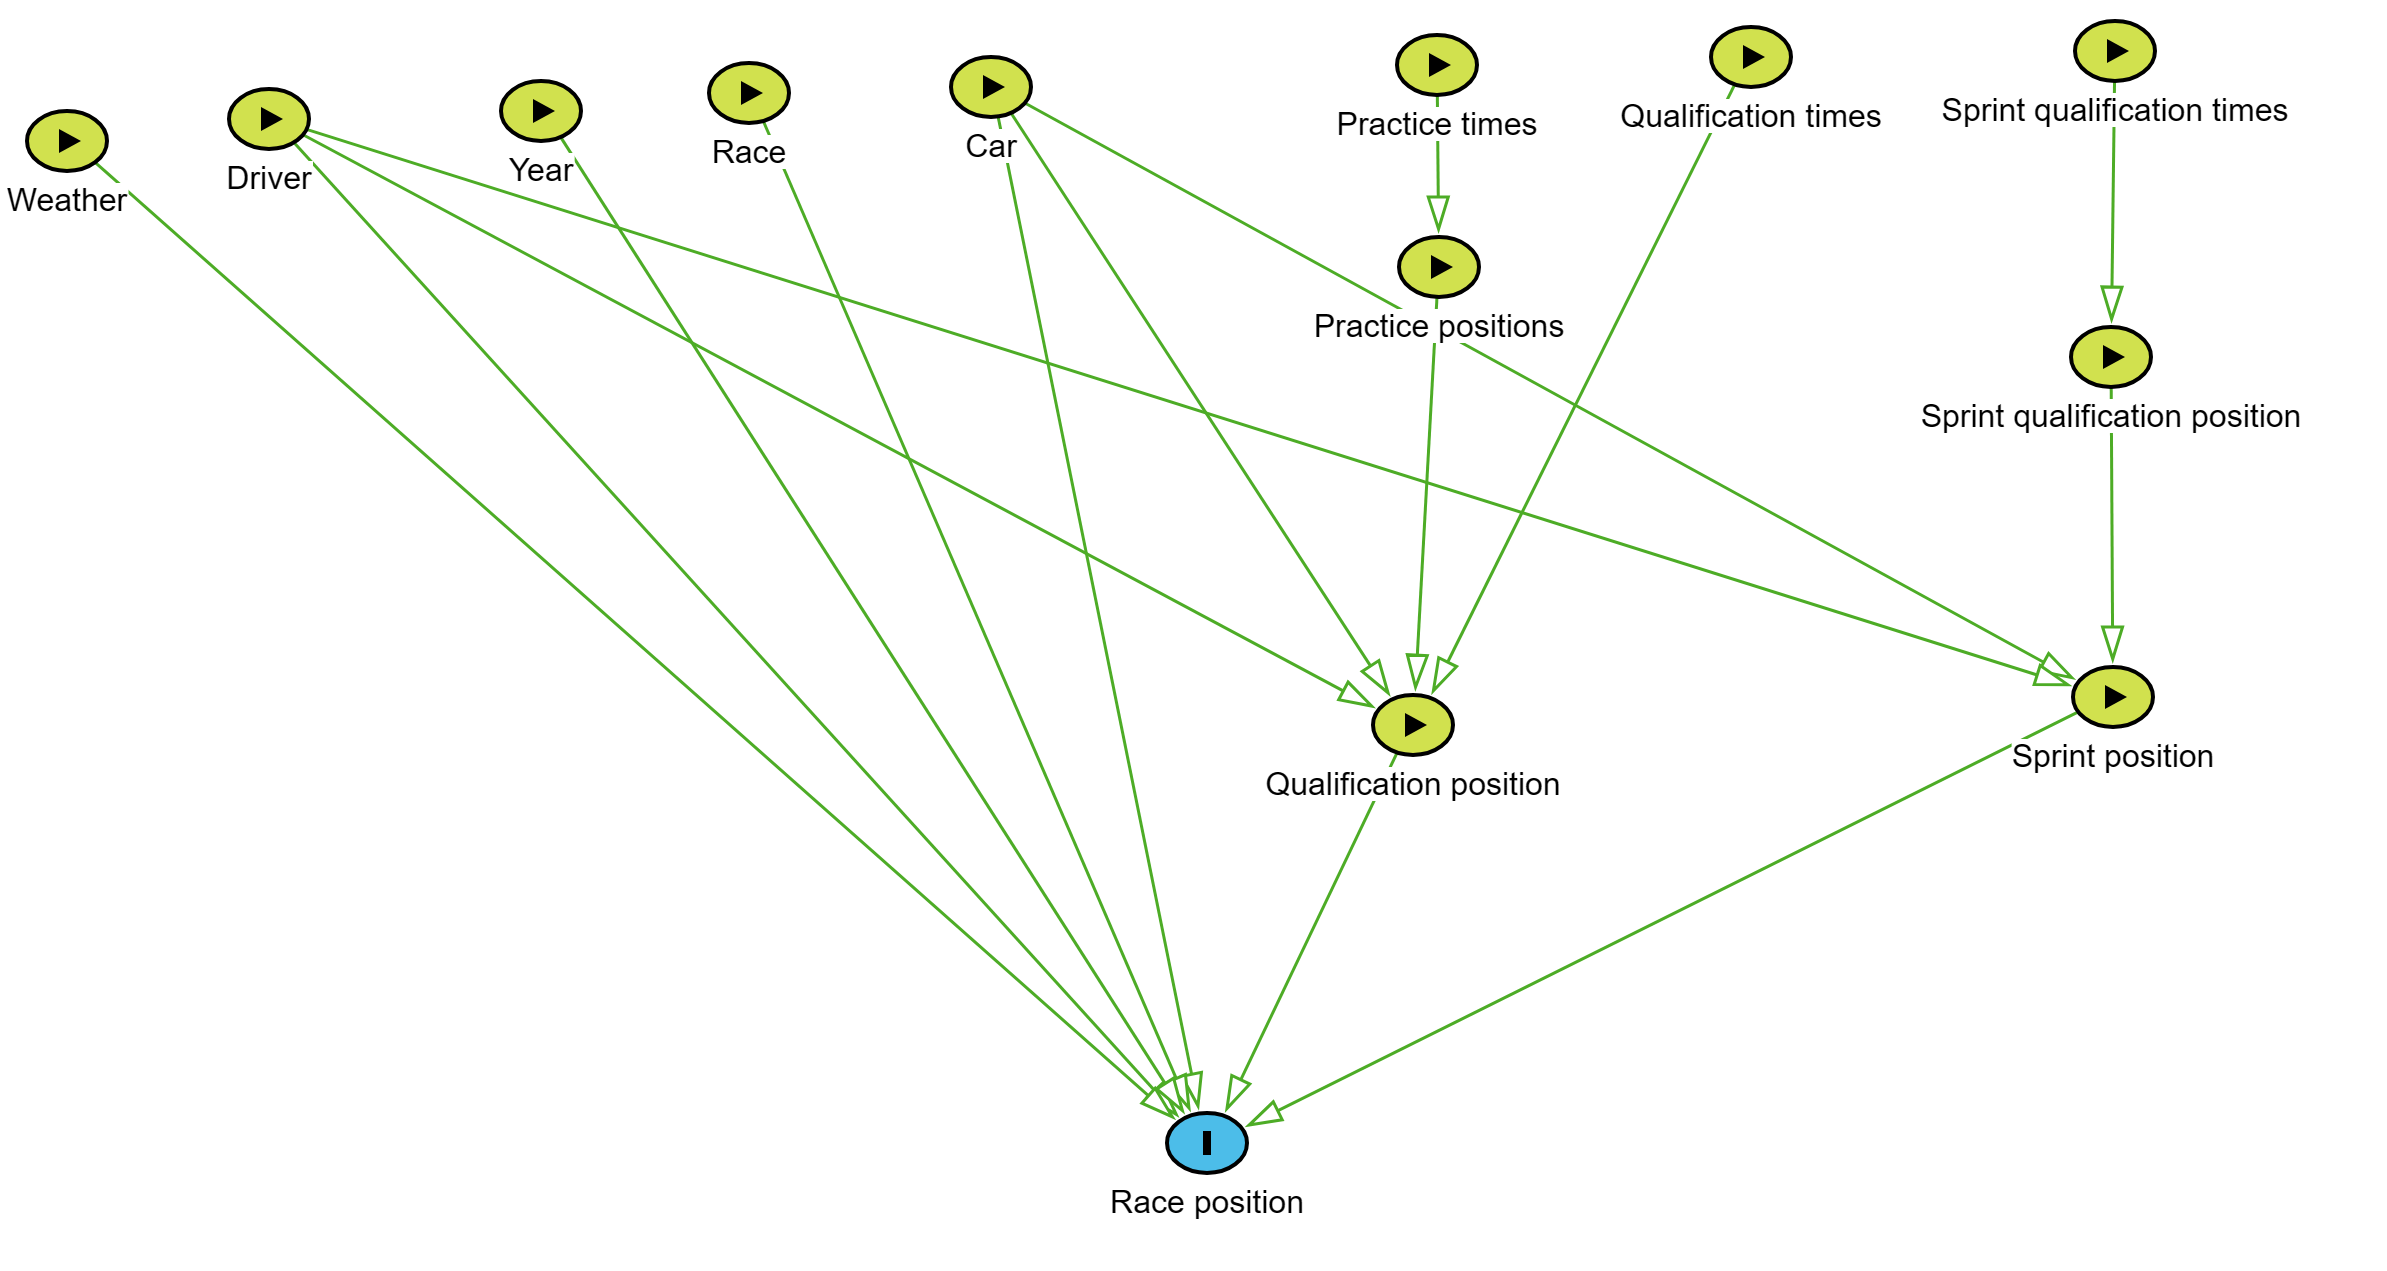

In [27]:
from PIL import Image
from IPython.display import display

DAG = Image.open('DAG.png')
display(DAG)

##### Confoundings
1. **Pipes**:
<br>Weather -> Race position,
<br>Driver -> Race position,
<br>Driver -> Qualification position -> Race position,
<br>Driver -> Sprint position -> Race position,
<br>Year -> Race position,
<br>Race -> Race position,
<br>Car -> Race position,
<br>Car -> Qualification position -> Race position,
<br>Car -> Sprint position -> Race position,
<br>Practice times -> Practice positions -> Qualification position -> Race position,
<br>Qualification times -> Qualification position,
<br>Sprint qualification times -> Sprint qualification position -> Race position.

2. **Forks**:
<br>Driver cause changes in Race position, Qualification position and Sprint position,
<br>Car cause changes in Race position, Qualification position and Sprint position.

3. **Colliders**:
<br>Qualification position and Sprint position cause changes in Race position which is our outcome of analysis.

### 2. Data Preprocessing

In [28]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [29]:
original_data = pd.read_csv('final_f1_data.csv')
original_data.head()

,Year,Race,No,Driver,Car,Pos (race),Laps (race),Time/Retired,Points,Pos (qualifying),...,SQ2,SQ3,Laps (Sprint Quali),AvgAirTemp,AvgHumidity,AvgPressure,TotalRainfall,AvgTrackTemp,AvgWindDirection,AvgWindSpeed
0,2022,Bahrain,16,Charles Leclerc LEC,Ferrari,1,57.0,1:37:33:584,26.0,1,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
1,2022,Bahrain,10,Pierre Gasly GAS,AlphaTauri RBPT,NC,44.0,DNF,0.0,10,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
2,2022,Bahrain,1,Max Verstappen VER,Red Bull Racing RBPT,19,54.0,DNF,0.0,2,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
3,2022,Bahrain,11,Sergio Perez PER,Red Bull Racing RBPT,18,56.0,DNF,0.0,4,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3
4,2022,Bahrain,27,Nico Hulkenberg HUL,Aston Martin Aramco Mercedes,17,57.0,+63.829s,0.0,17,...,NaN,NaN,NaN,23.62,29.49,1010.39,0,28.61,124.43,0.3


In [30]:
original_data.describe()

,Year,No,Laps (race),Points,Pos (FP1),Laps (FP1),Pos (FP2),Laps (FP2),Pos (FP3),Laps (FP3),Laps (Sprint),Points (Sprint),Laps (Sprint Quali),AvgAirTemp,AvgHumidity,AvgPressure,TotalRainfall,AvgTrackTemp,AvgWindDirection,AvgWindSpeed
count,1048.000000,1048.000000,998.000000,998.000000,996.000000,996.000000,805.000000,805.000000,777.000000,777.000000,219.000000,219.000000,160.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,2022.669847,27.684160,54.092184,5.105210,10.464859,21.462851,10.350311,25.371429,10.463320,18.615187,19.150685,1.808219,12.050000,24.150658,52.957653,987.579284,10.746183,35.564170,182.211422,1.888263
std,0.674099,23.115599,16.418655,7.259757,5.753720,7.594340,5.710601,7.053627,5.750751,4.703577,5.292381,2.647437,4.821075,4.787239,17.095960,52.604867,38.036584,8.090855,61.259309,1.018147
min,2022.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000,12.900000,7.110000,779.520000,0.000000,17.420000,87.800000,0.300000
25%,2022.000000,11.000000,50.000000,0.000000,5.000000,19.000000,5.000000,22.000000,5.000000,16.000000,19.000000,0.000000,8.000000,20.460000,42.320000,991.200000,0.000000,30.140000,132.640000,1.260000
50%,2023.000000,22.000000,57.000000,1.000000,10.000000,23.000000,10.000000,26.000000,10.000000,19.000000,19.000000,0.000000,12.000000,24.860000,54.160000,1008.650000,0.000000,35.520000,173.240000,1.530000
75%,2023.000000,44.000000,65.000000,9.750000,15.000000,26.000000,15.000000,30.000000,15.000000,22.000000,24.000000,3.500000,15.000000,27.505000,63.080000,1012.930000,0.000000,41.690000,220.330000,2.270000
max,2024.000000,99.000000,78.000000,26.000000,20.000000,39.000000,20.000000,44.000000,20.000000,31.000000,24.000000,8.000000,24.000000,36.570000,87.450000,1020.600000,250.000000,54.460000,314.130000,5.490000


In [31]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   1048 non-null   int64  
 1   Race                   1048 non-null   object 
 2   No                     1048 non-null   int64  
 3   Driver                 1048 non-null   object 
 4   Car                    1048 non-null   object 
 5   Pos (race)             998 non-null    object 
 6   Laps (race)            998 non-null    float64
 7   Time/Retired           998 non-null    object 
 8   Points                 998 non-null    float64
 9   Pos (qualifying)       998 non-null    object 
 10  Q1                     998 non-null    object 
 11  Q2                     744 non-null    object 
 12  Q3                     494 non-null    object 
 13  Pos (FP1)              996 non-null    float64
 14  Time (FP1)             959 non-null    object 
 15  Gap 

In [32]:
def remove_practice_only_drivers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove rows of drivers who only participated in practice sessions without racing.
    
    Args:
    df (pd.DataFrame): DataFrame containing F1 data with at least 'Pos (race)' column.
    
    Returns:
    pd.DataFrame: Cleaned DataFrame with only rows of drivers who participated in races.
    """
    # Check if 'Pos (race)' column exists
    if 'Pos (race)' not in df.columns:
        raise ValueError("DataFrame must contain 'Pos (race)' column.")
    
    # Iterate over DataFrame rows
    for index, row in df.iterrows():
        # Check if 'Pos (race)' value is missing or not a number
        if pd.isna(row['Pos (race)']) or (isinstance(row['Pos (race)'], str) and row['Pos (race)'].strip().lower() == 'nc'):
            # If missing or 'NC', drop the row
            df.drop(index, inplace=True)

    df.to_csv('test.csv', index=False)
    
    return df



data = remove_practice_only_drivers(original_data)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 874 entries, 0 to 1047
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   874 non-null    int64  
 1   Race                   874 non-null    object 
 2   No                     874 non-null    int64  
 3   Driver                 874 non-null    object 
 4   Car                    874 non-null    object 
 5   Pos (race)             874 non-null    object 
 6   Laps (race)            874 non-null    float64
 7   Time/Retired           874 non-null    object 
 8   Points                 874 non-null    float64
 9   Pos (qualifying)       873 non-null    object 
 10  Q1                     873 non-null    object 
 11  Q2                     659 non-null    object 
 12  Q3                     444 non-null    object 
 13  Pos (FP1)              830 non-null    float64
 14  Time (FP1)             802 non-null    object 
 15  Gap (

In [33]:
def fill_missing_qualifications_data(csv_path: str) -> pd.DataFrame:
    """
    Process F1 data by filling missing qualifying times with times from previous sessions.

    Args:
    csv_path (str): Path to the input CSV file containing F1 data.

    Returns:
    pd.DataFrame: Processed DataFrame with filled qualifying times.
    """
    # Load the CSV into a DataFrame
    df = pd.read_csv(csv_path)
    
    # Function to fill missing qualifying times
    def fill_qualifying_times(row):
        if pd.isnull(row['Q3']):
            row['Q3'] = row['Q2']
        if pd.isnull(row['Q2']) and pd.isnull(row['Q3']):
            row['Q2'] = row['Q1']
            row['Q3'] = row['Q1']
        return row
    
    def fill_sprint_qualifying_times(row):
        if pd.isnull(row['SQ3']):
            row['SQ3'] = row['SQ2']
        if pd.isnull(row['SQ2']) and pd.isnull(row['SQ3']):
            row['SQ2'] = row['SQ1']
            row['SQ3'] = row['SQ1']
        return row
    
    # Function to fill missing practice times
    def fill_practice_times(row):
        if pd.isnull(row['Time (FP1)']):
            if not pd.isnull(row['Time (FP2)']):
                row['Time (FP1)'] = row['Time (FP2)']
                row['Pos (FP1)'] = row['Pos (FP2)']
                row['Gap (FP1)'] = row['Gap (FP2)']
                row['Laps (FP1)'] = row['Laps (FP2)']
            elif not pd.isnull(row['Time (FP3)']):
                row['Time (FP1)'] = row['Time (FP3)']
                row['Pos (FP1)'] = row['Pos (FP3)']
                row['Gap (FP1)'] = row['Gap (FP3)']
                row['Laps (FP1)'] = row['Laps (FP3)']
        if pd.isnull(row['Time (FP2)']) and pd.isnull(row['Time (FP3)']):
            row['Time (FP2)'] = row['Time (FP1)']
            row['Pos (FP2)'] = row['Pos (FP1)']
            row['Gap (FP2)'] = row['Gap (FP1)']
            row['Laps (FP2)'] = row['Laps (FP1)']
        if pd.isnull(row['Time (FP3)']):
            row['Time (FP3)'] = row['Time (FP2)']
            row['Pos (FP3)'] = row['Pos (FP2)']
            row['Gap (FP3)'] = row['Gap (FP2)']
            row['Laps (FP3)'] = row['Laps (FP2)']
        return row


    # Apply the function to each row
    df = df.apply(fill_qualifying_times, axis=1)
    df = df.apply(fill_sprint_qualifying_times, axis=1)
    df = df.apply(fill_practice_times, axis=1)
    # Remove rows with remaining null values in the relevant columns
    # relevant_columns = ['Q1', 'Q2', 'Q3', 'Gap (FP1)', 'Gap (FP2)', 'Gap (FP3)','Time (FP1)', 'Time (FP2)', 'Time (FP3)']
    # df = df.dropna(subset=relevant_columns)
    df.to_csv('test2.csv', index=False)

    return df

# Example usage:
csv_path = 'test.csv'
data = fill_missing_qualifications_data(csv_path)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   874 non-null    int64  
 1   Race                   874 non-null    object 
 2   No                     874 non-null    int64  
 3   Driver                 874 non-null    object 
 4   Car                    874 non-null    object 
 5   Pos (race)             874 non-null    object 
 6   Laps (race)            874 non-null    float64
 7   Time/Retired           874 non-null    object 
 8   Points                 874 non-null    float64
 9   Pos (qualifying)       873 non-null    object 
 10  Q1                     873 non-null    object 
 11  Q2                     873 non-null    object 
 12  Q3                     873 non-null    object 
 13  Pos (FP1)              874 non-null    float64
 14  Time (FP1)             869 non-null    object 
 15  Gap (F

In [34]:
data = pd.read_csv('data_processing/processed_data.csv', sep=',')
data.head(5)

,Year,Race,No,Driver,Car,Pos (race),Points,Pos (qualifying),AvgAirTemp,AvgHumidity,AvgPressure,TotalRainfall,AvgTrackTemp,AvgWindDirection,AvgWindSpeed,Name
0,2022,Bahrain,16,1.7,1.6,1,26,1,23.62,29.49,1010.39,0,28.61,124.43,0.3,Charles Leclerc LEC
1,2022,Bahrain,10,1.4,1.0,20,0,10,23.62,29.49,1010.39,0,28.61,124.43,0.3,Pierre Gasly GAS
2,2022,Bahrain,1,2.1,1.8,19,0,2,23.62,29.49,1010.39,0,28.61,124.43,0.3,Max Verstappen VER
3,2022,Bahrain,11,1.3,1.8,18,0,4,23.62,29.49,1010.39,0,28.61,124.43,0.3,Sergio Perez PER
4,2022,Bahrain,27,1.1,1.9,17,0,17,23.62,29.49,1010.39,0,28.61,124.43,0.3,Nico Hulkenberg HUL


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              866 non-null    int64  
 1   Race              866 non-null    object 
 2   No                866 non-null    int64  
 3   Driver            866 non-null    float64
 4   Car               866 non-null    float64
 5   Pos (race)        866 non-null    int64  
 6   Points            866 non-null    int64  
 7   Pos (qualifying)  866 non-null    int64  
 8   AvgAirTemp        866 non-null    float64
 9   AvgHumidity       866 non-null    float64
 10  AvgPressure       866 non-null    float64
 11  TotalRainfall     866 non-null    int64  
 12  AvgTrackTemp      866 non-null    float64
 13  AvgWindDirection  866 non-null    float64
 14  AvgWindSpeed      866 non-null    float64
 15  Name              866 non-null    object 
dtypes: float64(8), int64(6), object(2)
memory us

In [36]:
data.describe()

,Year,No,Driver,Car,Pos (race),Points,Pos (qualifying),AvgAirTemp,AvgHumidity,AvgPressure,TotalRainfall,AvgTrackTemp,AvgWindDirection,AvgWindSpeed
count,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000,866.000000
mean,2022.690531,26.060046,1.401848,1.655889,9.874134,5.675520,9.872979,23.992021,53.281524,988.961432,10.983834,35.417055,180.247575,1.862956
std,0.680923,20.827419,0.377024,0.264979,5.607724,7.531347,5.609244,4.775764,16.988881,49.706541,38.507799,8.142864,60.416837,0.996102
min,2022.000000,1.000000,0.900000,1.000000,1.000000,0.000000,1.000000,12.900000,7.110000,779.520000,0.000000,17.420000,87.800000,0.300000
25%,2022.000000,11.000000,1.000000,1.600000,5.000000,0.000000,5.000000,20.460000,42.320000,991.200000,0.000000,30.140000,132.640000,1.140000
50%,2023.000000,20.000000,1.400000,1.700000,10.000000,1.000000,10.000000,24.310000,54.160000,1008.980000,0.000000,34.310000,171.260000,1.530000
75%,2023.000000,31.000000,1.600000,1.900000,15.000000,10.000000,15.000000,27.430000,63.080000,1012.930000,0.000000,41.690000,206.380000,2.270000
max,2024.000000,77.000000,2.200000,1.900000,20.000000,26.000000,20.000000,36.570000,87.450000,1020.600000,250.000000,54.460000,314.130000,5.490000


In [37]:
# data {
#   int<lower=1> N; // liczba obserwacji
#   array [N] real<lower=1, upper=20> qualifying_positions; // pozycje w kwalifikacjach
#   array [N] real driver_skill;
#   array [N] real car_skill;
# }

# generated quantities {
#   real alpha = abs(normal_rng(1.5, 0.8));
#   real beta = abs(normal_rng(1.5, 0.8));
#   real sigma = abs(normal_rng(2, 2));
#   array [N] real<lower=1, upper=20> y_prior;

#   // Generowanie danych z priorów
#   for (n in 1:N) {
#     y_prior[n] = normal_rng(qualifying_positions[n] + alpha * driver_skill[n] + beta * car_skill[n], sigma);
#   }
# }

In [38]:
import numpy as np

# Wartość lambda dla pierwszej obserwacji
lambda_1 = 36.06

# Generowanie wartości y_prior[1] z rozkładu Poissona o parametrze lambda_1
y_prior_1 = np.random.poisson(lambda_1)

print("Wygenerowana wartość y_prior[1]:", y_prior_1)

Wygenerowana wartość y_prior[1]: 45


In [39]:
# # %%writefile stan/model1.stan
# data {
#   int<lower=1> N; // liczba obserwacji
#   array [N] int<lower=1, upper=20> qualifying_positions; // pozycje w kwalifikacjach
#   vector[N] driver_skill;
#   vector[N] car_skill;
# }

# generated quantities {
#   real<lower=0> alpha;
#   real<lower=0> beta;
#   // array [N] int<lower=1, upper=20> y_prior;
#   // array [N] real<lower=0> lambda;

#   // Priory
#   alpha = normal_rng(0, 1);
#   beta = normal_rng(0, 1);

#   // Generowanie danych z priorów
#   // for (n in 1:N) {
#     // lambda[n] = qualifying_positions[n] - beta * driver_skill[n] - beta * car_skill[n];
#     // y_prior[n] = poisson_log_rng(lambda[n]);
#   // }
#   real pos = normal_rng(alpha, beta);
# }

In [116]:
%%writefile stan/model1.stan

data {
    int N;
    array [N] int<lower=1> qualifying_positions;
    array [N] real driver_skills;
    array [N] real car_skills;
}

generated quantities {
    array [N] real lambda;
    array [N] int<lower=1, upper=20> race_position;
    real alpha = normal_rng(0.1, 0.1);
    real beta = normal_rng(0.1, 0.1);
    real<lower=1, upper=20> quali = normal_rng(10, 5);
    //real alpha = normal_rng(1.6, 0.8);
    //real beta = normal_rng(1.6, 0.8);
    real<lower=0, upper=1> theta = normal_rng(0.5, 0.5);

    for (n in 1:N) {
        lambda[n] = qualifying_positions[n] + alpha * driver_skills[n] + beta * car_skills[n];
        // lambda[n] = qualifying_positions[n];
        lambda[n] = quali + alpha * driver_skills[n] + beta * car_skills[n];
        // race_position[n] = poisson_rng(lambda[n]);
        // race_position[n] = binomial_rng(N, theta);
    }
}


Overwriting stan/model1.stan


In [70]:
# %%writefile stan/model1.stan
# data {
#     int N;
#     array[N] int<lower=1> qualifying_positions;
#     array[N] real driver_skills;
#     array[N] real car_skills;
# }

# generated quantities {
#     array[N] real lambda;
#     array[N] int race_position;
#     real alpha = normal_rng(0, 0.1);
#     real beta = normal_rng(0, 0.1);
#     for (n in 1:N) {
#         lambda[n] = qualifying_positions[n] + alpha * driver_skills[n] + beta * car_skills[n];
#         race_position[n] = binomial_rng(20, lambda[n] / 20); // 20 to górna granica
#     }
# }


In [117]:
df = pd.read_csv('data_processing/processed_data.csv')

# Przekształć dane na format listy lub numpy arrays
# qualifying_positions = [1.0, 2.0, 3.0, 4.0, 5.0]
# driver_skills = [1.0, 2.0, 3.0, 4.0, 5.0]
# car_skills = [1.0, 2.0, 3.0, 4.0, 5.0]
qualifying_positions = df['Pos (qualifying)'].values
driver_skills = df['Driver'].values
car_skills = df['Car'].values


R = 866
data_dict = {
    'N': R,
    'qualifying_positions': qualifying_positions,
    'driver_skills': driver_skills,
    'car_skills': car_skills
}

In [118]:
# Kompilacja modelu
model = CmdStanModel(stan_file='stan/model1.stan')

# Dopasowanie modelu do danych
qualifying_positions = df['Pos (qualifying)'].values
R = 866
fit = model.sample(data=data_dict, iter_warmup=1000, iter_sampling=R, fixed_param=True, chains=1, seed=20052024)
# fit = model.sample(data={'N': R, 'qualifying_positions': qualifying_positions,}, iter_warmup=1000, iter_sampling=R, fixed_param=True, chains=1, seed=20052024)

# Wyciągnięcie wygenerowanych danych z priorów
# prior_y_rep = fit.stan_variable('race_position')

INFO:cmdstanpy:compiling stan file /home/bayesian_f1/stan/model1.stan to exe file /home/bayesian_f1/stan/model1
INFO:cmdstanpy:compiled model executable: /home/bayesian_f1/stan/model1
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


In [113]:
# Wyciągnięcie wygenerowanych danych z priorów
prior_y_rep = fit.stan_variable('race_position')
prior_y_rep

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [114]:
dff = fit.draws_pd()
dff.head(15)

,lp__,accept_stat__,lambda[1],lambda[2],lambda[3],lambda[4],lambda[5],lambda[6],lambda[7],lambda[8],...,race_position[861],race_position[862],race_position[863],race_position[864],race_position[865],race_position[866],alpha,beta,quali,theta
0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


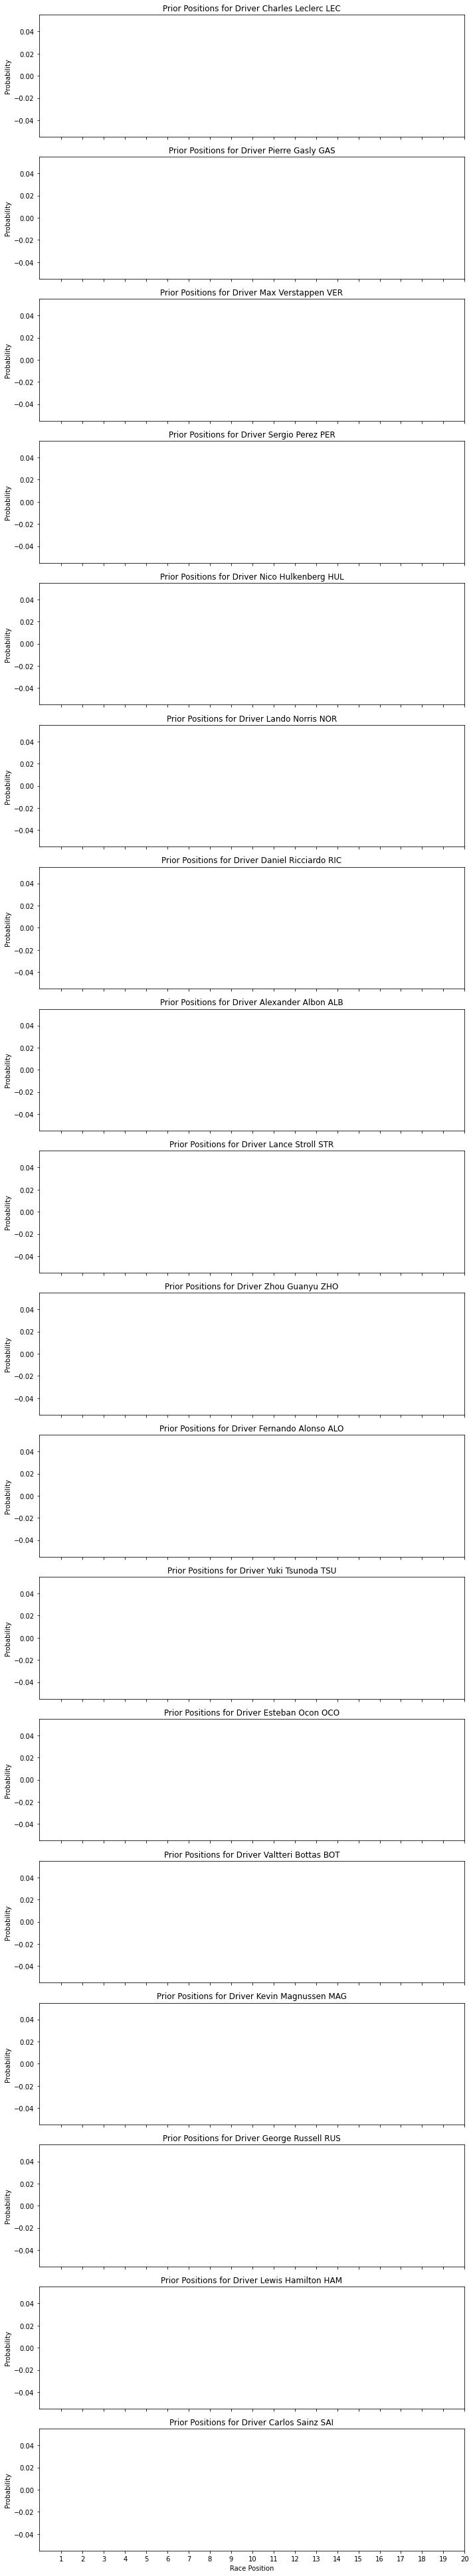

In [115]:
# Pobieramy unikalnych kierowców
drivers = df['Name'].unique()
# Inicjalizacja subplots
fig, axes = plt.subplots(len(drivers), 1, figsize=(10, len(drivers) * 3), sharex=True)

# Jeżeli mamy tylko jednego kierowcę, osie będą jednowymiarowe, więc musimy je dostosować
if len(drivers) == 1:
    axes = [axes]

# Iterujemy przez każdego kierowcę i tworzymy histogram
for i, driver in enumerate(drivers):
    # Indeksowanie danych dla danego kierowcy
    driver_indices = df[df['Name'] == driver].index
    driver_y_prior = prior_y_rep[:, i]
    
    # Spłaszczamy dane do jednowymiarowej tablicy
    driver_y_prior_flat = driver_y_prior.flatten()
    
    # Tworzymy histogram za pomocą seaborn z normalizacją do prawdopodobieństwa
    sns.histplot(driver_y_prior_flat, bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7, ax=axes[i], stat='probability')
    axes[i].set_title(f'Prior Positions for Driver {driver}')
    axes[i].set_ylabel('Probability')
    axes[i].set_xticks(range(1, 21))

axes[-1].set_xlabel('Race Position')
plt.tight_layout()
plt.show()

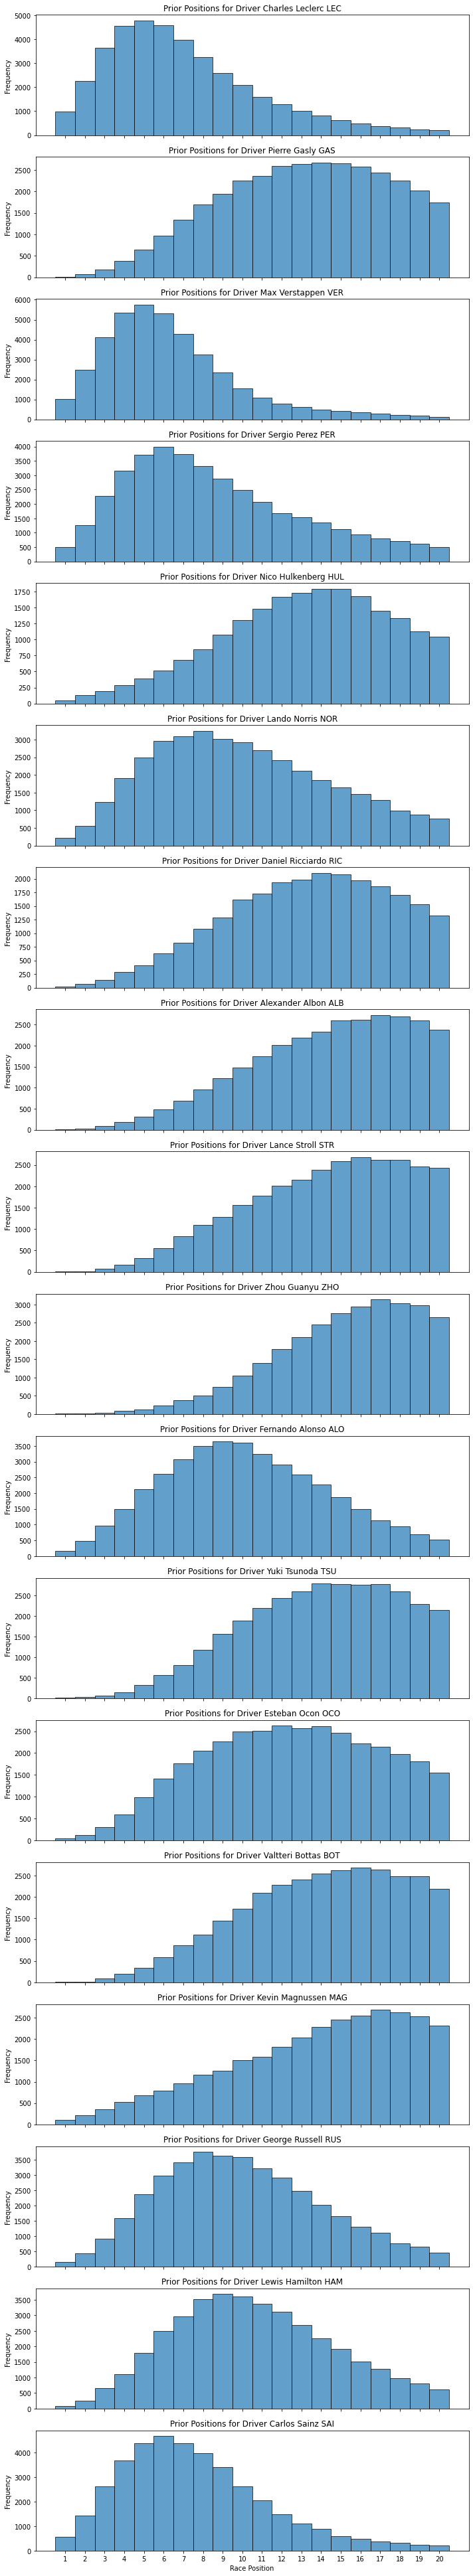

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Pobieramy unikalnych kierowców
drivers = df['Name'].unique()

# Inicjalizujemy subplots
fig, axes = plt.subplots(len(drivers), 1, figsize=(10, len(drivers) * 3), sharex=True)

# Jeżeli mamy tylko jednego kierowcę, osie będą jednowymiarowe, więc musimy je dostosować
if len(drivers) == 1:
    axes = [axes]

# Iterujemy przez każdego kierowcę i tworzymy histogram
for i, driver in enumerate(drivers):
    # Indeksowanie danych dla danego kierowcy
    driver_indices = df[df['Name'] == driver].index
    driver_y_prior = prior_y_rep[:, driver_indices]
    
    # Spłaszczamy dane do jednowymiarowej tablicy
    driver_y_prior_flat = driver_y_prior.flatten()
    
    # Tworzymy histogram
    axes[i].hist(driver_y_prior_flat, bins=np.arange(1, 22) - 0.5, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Prior Positions for Driver {driver}')
    axes[i].set_ylabel('Frequency')
    axes[i].set_xticks(range(1, 21))

axes[-1].set_xlabel('Race Position')
plt.tight_layout()
plt.show()

In [77]:
%%writefile stan/test.stan
data {
  int<lower=1> N;                // Liczba obserwacji
  int<lower=1> K;                // Liczba kategorii
  array[N] real<lower=0, upper=2> d;    // driver_skill
  array[N] real<lower=0, upper=2> ds;   // driver skill seasonal
  array[N] real<lower=0, upper=2> t;    // car skill
  array[N] real<lower=0, upper=2> ts;   // car skill seasonal
}

parameters {
  real<lower=0> sigma_d; // Odchylenie standardowe dla driver_skill
  real<lower=0> sigma_ds; // Odchylenie standardowe dla driver skill seasonal
  real<lower=0> sigma_t; // Odchylenie standardowe dla car skill
  real<lower=0> sigma_ts; // Odchylenie standardowe dla car skill seasonal
  ordered[K-1] cutpoints;  // Punkty odcięcia dla ordered logistic
}

model {
  // Priory
  sigma_d ~ normal(0, 1);
  sigma_ds ~ normal(0, 1);
  sigma_t ~ normal(0, 1);
  sigma_ts ~ normal(0, 1);
  cutpoints ~ normal(0, 1);
}

generated quantities {
  // Wyznaczanie pozycji kierowców
  array[N] int<lower=1, upper=K> position;
  vector[N] param;
  for (i in 1:N) {
    param[i] = d[i] * sigma_d + ds[i] * sigma_ds + t[i] * sigma_t + ts[i] * sigma_ts;
    position[i] = ordered_logistic_rng(param[i], cutpoints);
  }
}










Overwriting stan/test.stan


In [78]:
df = pd.read_csv('data_processing/processed_data.csv')
qualifying_positions = df['Pos (qualifying)'].values

import numpy as np

# Dane
N = 100  # liczba obserwacji
K = 20   # liczba kategorii
d = np.random.uniform(0, 2, size=N)    # driver_skill
ds = np.random.uniform(0, 2, size=N)   # driver skill seasonal
t = np.random.uniform(0, 2, size=N)    # car skill
ts = np.random.uniform(0, 2, size=N)   # car skill seasonal

# Tworzenie danych dla modelu
data = {
    'N': N,
    'K': K,
    'd': d,
    'ds': ds,
    't': t,
    'ts': ts
}


In [79]:
# Kompilacja modelu
stan_model = CmdStanModel(stan_file='stan/test.stan')

# Dopasowanie modelu do danych
result = stan_model.sample(data=data, chains=4, iter_sampling=1000, iter_warmup=500)

INFO:cmdstanpy:compiling stan file /home/bayesian_f1/stan/test.stan to exe file /home/bayesian_f1/stan/test
INFO:cmdstanpy:compiled model executable: /home/bayesian_f1/stan/test
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▌         | 00:00 Status


chain 1 |██▎       | 00:00 Iteration:  200 / 1500 [ 13%]  (Warmup)

chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)



chain 1 |██████▍   | 00:00 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |████████▊ | 00:01 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |██████████| 00:01 Iteration: 1400 / 1500 [ 93%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


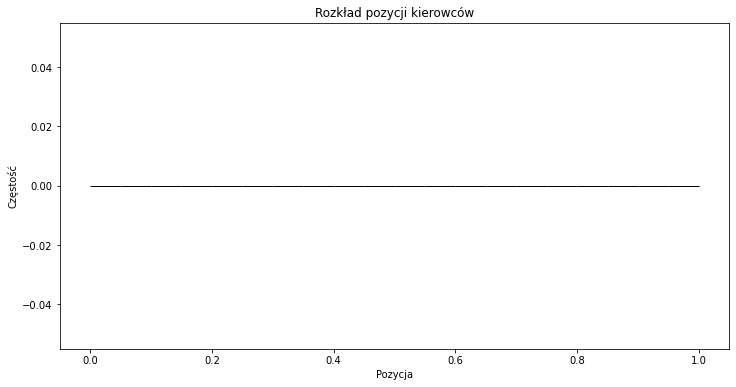

In [80]:
# Ekstrakcja wyników
df = result.draws_pd()

# Wyciągnięcie pozycji kierowców
positions = df.filter(regex=r'^position\.\d+$')

# Przekształcenie danych do formatu długiego
positions_long = positions.melt(var_name='observation', value_name='position')

# Wyciągnięcie numeru obserwacji
positions_long['observation'] = positions_long['observation'].str.extract(r'(\d+)').astype(int)

# Wizualizacja rozkładu pozycji kierowców
plt.figure(figsize=(12, 6))
sns.histplot(data=positions_long, x='position', bins=K, kde=True)
plt.xlabel('Pozycja')
plt.ylabel('Częstość')
plt.title('Rozkład pozycji kierowców')
plt.show()

In [81]:
df = result.draws_pd()
df.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma_d,sigma_ds,sigma_t,...,param[91],param[92],param[93],param[94],param[95],param[96],param[97],param[98],param[99],param[100]
0,-54.9913,0.989464,0.149307,5.0,31.0,0.0,72.6571,0.690384,0.915068,1.103690,...,1.708710,5.23026,2.603110,3.047210,5.81941,4.60980,4.85457,1.863260,5.80393,5.25853
1,-52.3505,0.996285,0.149307,5.0,31.0,0.0,64.1857,1.155060,0.960232,0.888889,...,1.555770,5.13535,2.851690,2.831210,4.96105,4.08426,4.26332,1.853580,5.23081,4.82304
2,-53.2949,0.938367,0.149307,5.0,31.0,0.0,65.7460,0.394402,1.089970,0.978458,...,1.555470,4.47070,2.294500,2.204170,5.08372,4.13731,4.28680,1.227240,4.25252,4.72635
3,-57.7675,0.895386,0.149307,5.0,31.0,0.0,67.8841,0.094781,0.964337,0.542289,...,0.944632,2.59973,1.433760,0.932986,3.05577,2.56386,2.61553,0.392468,1.76468,2.95926
4,-59.0859,0.939788,0.149307,5.0,31.0,0.0,75.1341,0.052313,0.269607,0.337792,...,0.489611,1.31296,0.619089,0.677512,1.56679,1.26268,1.30597,0.371492,1.37111,1.41140
